### Libraries

In [1]:
import importlib

import config as Config
import constants.labels as Labels
import hangar.FirmBomberFactory as FirmBomberFactory
import hangar.FundBomberFactory as FundBomberFactory
import hangar.DisplayModule as DisplayModule
import models.firm as FirmModel
import models.funding as FundingModel
import models.investor as InvestorModel
import models.macro as MacroModel
import utils.file as FileUtils
import utils.industry as IndustryUtils
import utils.visualiser as Visualiser
import utils.tests as Tests
from scipy.stats import linregress
from statsmodels.tsa.seasonal import STL

import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
import statsmodels.api as sm

def reload():
  importlib.reload(Config)
  importlib.reload(Visualiser)
  importlib.reload(DisplayModule)
  importlib.reload(Tests)
  importlib.reload(FirmBomberFactory)

### Configuration
Configuration specified in src/config.js to avoid passing the same configurations around. Modify configurations as required, then run reload() to reload configurations without restarting the environment.

### Load Data
Data obtained from Crunchbase and CEIC (for macro data), preprocessed, then stored in pickle files. This section retrieves the stored data and does additional preprocessing.

#### Load Investor Data

In [2]:
# Read Investor Data
investors = FileUtils.read_pickle(f"investors")

In [3]:
# Get Public Funded Investors
public_funded_investors = InvestorModel.get_public_funded_investors(investors)

#### Load Company Data

In [4]:
# Read Company Data
firms = FileUtils.read_pickle(f"{Config.country}_firms")

In [5]:
# Read Domain Data
domain_created_year = FileUtils.read_pickle('domain_created_year')

In [6]:
# Filter and Enrich Company Data
firms = FirmModel.filter_for_profit(firms)
firms = FirmModel.enrich_founded_year(firms, domain_created_year)
firms = FirmModel.filter_founded_year(firms, Config.start_year, Config.end_year)
firms = FirmModel.enrich_public_funded(firms, public_funded_investors)
firms = firms.reset_index(drop=True)

#### Load Funding Data

In [7]:
# Read Funding Data
funding = FileUtils.read_pickle(f"funding")

In [8]:
# Filter and Enrich Funding Data
funding = FundingModel.filter_announced_year(funding, Config.start_year, Config.end_year)
funding = FundingModel.enrich_public_funded(funding, public_funded_investors)

#### Load Macro Data

In [9]:
# Read Macro Data
real_gdp = FileUtils.read_pickle('real_gdp')
fed_rate = FileUtils.read_pickle('fed_rate')

In [10]:
# Filter Macro Data
real_gdp = real_gdp['United States']
real_gdp = real_gdp[real_gdp.index >= Config.start_year]
real_gdp = real_gdp[real_gdp.index < Config.end_year]

fed_rate = fed_rate['Fed Rate']
fed_rate = fed_rate[fed_rate.index >= Config.start_year]
fed_rate = fed_rate[fed_rate.index < Config.end_year]

In [11]:
# Store Macro Data
macro = MacroModel.Macro(real_gdp, fed_rate)

### Load Other Data

In [12]:
# Industry Labels
industry_groups = IndustryUtils.get_industry_groups()
industries = IndustryUtils.get_industries()

### Preprocess Data

In [73]:
# Load Bombers
reload()
firm_bomber_i = FirmBomberFactory.FirmBomber(firms, targets=industries, target_col=Labels.industries)
firm_bomber_ig = FirmBomberFactory.FirmBomber(firms, targets=industry_groups, target_col=Labels.industry_groups)

In [85]:
# Load Bombers
fund_bomber_i = FundBomberFactory.FundBomber(funding, targets=industries, target_col=Labels.industries)
fund_bomber_ig = FundBomberFactory.FundBomber(funding, targets=industry_groups, target_col=Labels.industry_groups)

### Research Question: "Trend-Following"
Have company founders and investors become more prone to trend-following over time, rather than relying on their own judgement? Trend-following results in bubbly behaviour, with sharp spikes and sharp drops, likely cause issues as bad causes are funded in the bubble and good causes are not funded in the crash. Note that a bubble can be defined as "trend-following" or as "deviation from fundamentals"; it's possible to follow a trend and by coincidence approach the fundamentals, though this likely does not hold true in the long run. I will use the "trend-following" definition, since "fundamental" are difficult to define, and understanding trend-following behaviour is still is empirically useful.

I use a year range of 1960 to 2019 as that is what is available on both Crunchbase and CEIC (for macro data), as well as to avoid what looks like incomplete data post 2019. There are dramatically few companies being reported to be founded around that time period, which may be partially attributed to the Coronavirus pandemic, but is still somewhat suspect.

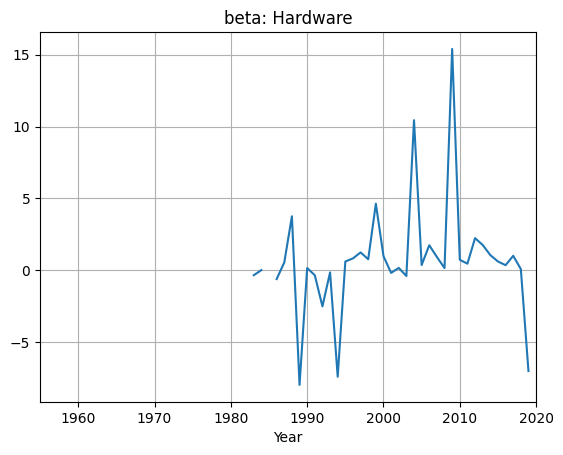

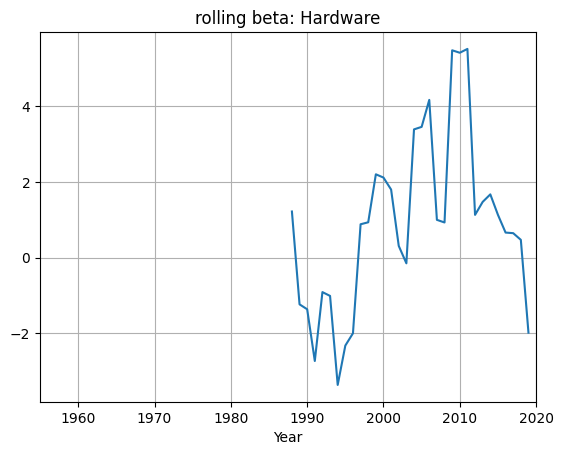

mean: 0.6394234230695987
mean_roll: 0.9037051267634213
                              year                 industry     value  \
entity                  time                                            
Administrative Services 1989  1989  Administrative Services       0.0   
                        1991  1991  Administrative Services       0.0   
                        1996  1996  Administrative Services      -6.0   
                        1997  1997  Administrative Services  0.083333   
                        1998  1998  Administrative Services  6.857143   
...                            ...                      ...       ...   
Video                   2015  2015                    Video  0.591653   
                        2016  2016                    Video -0.165771   
                        2017  2017                    Video  4.960801   
                        2018  2018                    Video  0.754702   
                        2019  2019                    Video   2.15795

/Users/celine/Projects/IO/venv/lib/python3.8/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [154]:
all = False
spy = True
# spy = False
spy_index = 'Hardware'

# reload()
# Convert data to data frame for panel regression
df = pd.DataFrame(fund_bomber_ig.year_count_growth_beta_map)
Tests.panel(df, year_col='year', value_col='industry')



In [16]:
# Generate sample data
np.random.seed(0)
n = 100  # number of entities
T = 10   # number of time periods

# Creating a DataFrame for panel data
index = pd.MultiIndex.from_product([range(n), range(T)], names=['entity', 'time'])
data = pd.DataFrame({'X': np.random.randn(n * T),
                     'Y': np.random.randn(n * T),
                     'Z': np.random.randn(n * T),
                     'W': np.random.randn(n * T)}, index=index)

# Adding a constant term
data['const'] = 1

print(data)

# Panel regression
model = PanelOLS(data['Y'], data[['X', 'Z', 'W', 'const']], entity_effects=True, time_effects=True)
results = model.fit()

# print(results)

estimated_effects = results.estimated_effects
print(estimated_effects)

entity_effects = estimated_effects.groupby('entity').mean()
time_effects = estimated_effects.groupby('time').mean()
print(entity_effects)
print(time_effects)

                    X         Y         Z         W  const
entity time                                               
0      0     1.764052  0.555963 -1.532921  1.593274      1
       1     0.400157  0.892474 -1.711970  0.568722      1
       2     0.978738 -0.422315  0.046135 -0.114487      1
       3     2.240893  0.104714 -0.958374  0.251630      1
       4     1.867558  0.228053 -0.080812 -1.210856      1
...               ...       ...       ...       ...    ...
99     5     0.412871  0.097751  2.079177 -0.503890      1
       6    -0.198399  1.401523 -0.907466  1.779559      1
       7     0.094192  0.158434 -0.192404 -0.030572      1
       8    -1.147611 -1.141901 -1.212516  1.577088      1
       9    -0.358114 -1.310970 -0.080599 -0.812802      1

[1000 rows x 5 columns]
             estimated_effects
entity time                   
0      0              0.035415
       1             -0.007530
       2              0.053243
       3              0.088470
       4              